*This notebook can be found on* [github](https://github.com/qojulia/QuantumOptics.jl-examples/tree/master/notebooks/quantum-zeno-effect.ipynb)

# Quantum Zeno Effect

In this example, we will use a stochastic master equation approach in order to describe the dynamics of an atom inside a cavity, where the cavity is subject to homodyne detection. The example was inspired by the work of Nielsen and Mølmer [1], but the setup treated here is somewhat simplified.

The physical model is as follows: a two-level atom with two states $|f\rangle$ and $|g\rangle$ is placed inside a cavity. However, instead of the usual Jaynes-Cummings type interaction, only the state $|f\rangle$ interacts with the cavity. (Note, that this situation can be reached when considering a three-level atom with two ground states $|f\rangle$ and $|g\rangle$, where the cavity couples to the transition between $|f\rangle$ and the excited state, but is so far detuned that the excited state may be adiabatically eliminated.) This system is described by the Hamiltonian

$H_0 = g a^\dagger a ~n$,

where $n=|f\rangle\langle f|$. The cavity is also coherently driven through one mirror and detected at the output of the other. The coherent drive is described by the Hamiltonian

$H_\text{d} = -i\beta\left(a^\dagger - a\right),$

where $\beta$ is the amplitude of the drive. Also, the atom is coherently driven with amplitude $g_s,$

$H_\text{p} = g_s\sum_i\left(\sigma_i^+ + \sigma_i^-\right),$

The cavity decays through the other mirror at a rate $\kappa$, which is described by the Lindblad term

$\mathcal{D}[c]\rho = c\rho c^\dagger - \frac{1}{2}\left(c^\dagger c\rho - \rho c^\dagger c\right),$

where $c=\sqrt{\kappa}a$ is the collapse operator. The information gain (partial collapse of the wave function) due to the detection is described by the measurement super operator $\mathcal{H}[c],$

$\mathcal{H}[c]\rho = c\rho + \rho c^\dagger -\langle c + c^\dagger\rangle \rho,$

where the last term $\langle c + c^\dagger\rangle \rho$ ensures trace conservation.

For the measurement, we set $c=\sqrt{\kappa_2}a$, where, realistically, $\kappa_2 \leq \kappa$ and $\kappa_2 < \kappa$ describes detection with less than unit efficiency.

The system is then described by the linear stochastic master equation

$\dot{\rho} = -i[H,\rho] + \left(\kappa\mathcal{D}[a]\rho + \sqrt{\kappa_2}\mathcal{H}[a]\rho \xi(t)\right),$

where $H=H_0+H_\text{d}+H_\text{p}$ and $\xi(t)$ is white noise. This equation is straightforward to implement using `stochastic.master`.

For a nice and rigorous derivation and discussion of the above stochastic master equations, we refer to Ref. [2].

We proceed as usual by loading the needed libraries, defining the parameters and the Hilbert space and the operators of the system.

In [1]:
using QuantumOptics
using PyPlot

In [2]:
# Parameters
Nc = 3
κ = 1.0
κ₂ = 0.3κ
g = 0.2κ
β = 0.2*sqrt(κ)
gₛ = 5*1e-2κ
T = [0:0.1:3/gₛ;]

# Basis and operators
bc = FockBasis(Nc)
ba = SpinBasis(1//2)

a = destroy(bc) ⊗ one(ba)
ad = create(bc) ⊗ one(ba)
σ⁺ = one(bc) ⊗ sigmap(ba)
σ = one(bc) ⊗ sigmam(ba)
n = σ⁺*σ;

In [3]:
# Hamiltonian
H0 = g*ad*a*n
Hp = gₛ*(σ⁺ + σ)

# Coherent drive of cavity
Hf = -1.0im*β*(ad - a)

H = H0 + Hf + Hp

# Damping operators of master equation
J = [a]
rates = [κ];

Now, we define the stochastic jump operators, which are to be applied as shown above for $\mathcal{H}[c]$.

In [4]:
# Stochastic damping operators
C = [sqrt(κ₂)*a];

We initialize the atom in the state $|g\rangle$, which corresponds to the `spindown` state and the cavity in a vacuum state.

In [5]:
# Initial state
ψ0 = fockstate(bc, 0) ⊗ spindown(ba)
ρ0 = dm(fockstate(bc, 0) ⊗ spindown(ba));

Finally, we pass the above definitions to the stochastic master equation in order to obtain our results.

In [6]:
# Solve stochastic master equation
dt = 1e-3
tout, ρt = stochastic.master(T, ρ0, H, J, C; rates=rates, dt=dt);

In addition, we calculate the same time evolution once more, but with a unit efficiency detector and a reduced pump strength $g_s$.

In [7]:
C_zeno = [sqrt(κ)*a]
gₛ_zeno = 1e-3κ
Hp_zeno = gₛ_zeno*(σ⁺ + σ)
H_zeno = H0 + Hf + Hp_zeno
T_zeno = [0:1:3/gₛ_zeno;]

tout_zeno, ρt_zeno = stochastic.master(T_zeno, ρ0, H_zeno, J, C_zeno; rates=rates, dt=dt);

As reference, we also calculate the time evolution where the coupling to the cavity is zero, i.e. the atoms will simply oscillate between $|f\rangle$ and $|g\rangle$.

In [8]:
# Compute time evolution with no coupling to the cavity
tout2, ρt_det = timeevolution.master(T, ρ0, H - g*ad*a*n, J; rates=rates);

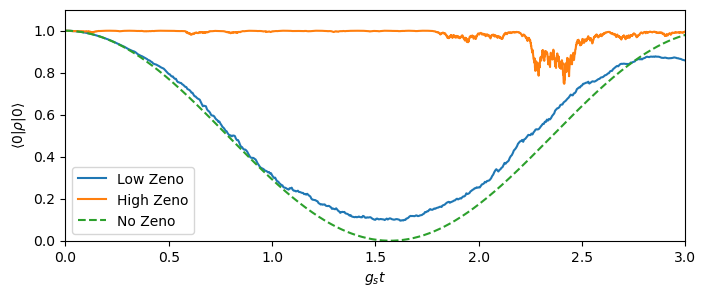

In [9]:
# Calculate expectation value of atoms in |f>
proj = one(bc) ⊗ dm(spindown(ba))
p0 = real(expect(proj, ρt))
p0_zeno = real(expect(proj, ρt_zeno))
p0_det = real(expect(proj, ρt_det))

figure(figsize=(8, 3))
plot(tout.*gₛ, p0, label="Low Zeno")
plot(tout_zeno.*gₛ_zeno, p0_zeno, label="High Zeno")
plot(tout2.*gₛ, p0_det, ls="dashed", label="No Zeno")
axis([0, T[end]*gₛ, 0, 1.1])
xlabel(L"$g_s t$")
ylabel(L"$\langle 0|\rho|0\rangle$")
legend();

We can clearly see, that while the unperturbed atom undergoes a full Rabi cycle from $|f\rangle$ to $|g\rangle$ and back, that as soon as the system is subject to measurement noise, transitions of the atom are somewhat inhibited. If the collapse due to the measurement is very large, then the probability almost vanishes. This is called the Quantum Zeno effect.



**References**

[1] Nielsen, A. E. B. and Mølmer, K. *Stochastic master equation for a probed system in a cavity*, Phys. Rev. A 77, 052111, (2008). URL: [https://arxiv.org/abs/0802.1225](https://arxiv.org/abs/0802.1225)

[2] Jacobs, K. and Steck, D. A. *A straighforward introduction to continuous quantum measurements*, Contemporary Physics, 47:5, 279-303, (2006). URL: [https://arxiv.org/abs/quant-ph/0611067](https://arxiv.org/abs/quant-ph/0611067)